In [1]:
# import libraries and functions
!pip install ISLP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, cm
import sklearn.model_selection as skm
from sklearn.preprocessing import StandardScaler
from ISLP import load_data, confusion_table
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
import seaborn as sns

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=50c424f9a065cfc7bd51a6b5fac8de1bab1cd2f2b7036beda9be3f31be517f78
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load data and create classification Y category
df = pd.read_csv('/content/drive/My Drive/datasci 415 project/full_dataset.csv')
df['winner_2020_encoded'] = df['winner_2020'].apply(lambda x: 1 if x == 'Democrat' else -1)
df['State'] = df['State'].astype('category')

# create new variable for the average proportion of people who voted in each county
df['average_pop'] = (df['Population.2010 Population']+ df['Population.2020 Population'])/2
df['average_total_votes_prop'] =  ((df['total_votes_2016'] + df['total_votes_2012'] + df['total_votes_2008'] + df['total_votes_2004'] + df['total_votes_2000']) / 5)/df['average_pop']

In [4]:
# view correlation matrix to find milticollinearity
num_data = df.select_dtypes(include=[np.number])
corr = num_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age.Percent 65 and Older,Education.Bachelor's Degree or Higher,Education.High School or Higher,Ethnicities.Hispanic or Latino,Ethnicities.White Alone,Ethnicities.White Alone not Hispanic or Latino,Housing.Households,Housing.Persons per Household,Income.Median Houseold Income,Income.Per Capita Income,Miscellaneous.Foreign Born,Miscellaneous.Land Area,Miscellaneous.Language Other than English at Home,Miscellaneous.Living in Same House +1 Years,Miscellaneous.Percent Female,Population.2020 Population,Population.2010 Population,Population.Population per Square Mile,Employment.Firms.Total,Employment.Firms.Women-Owned,Employment.Firms.Men-Owned,Employment.Firms.Minority-Owned,Employment.Firms.Nonminority-Owned,Employment.Firms.Veteran-Owned,Employment.Firms.Nonveteran-Owned,county_fips,total_votes_2020,total_votes_2016,total_votes_2012,total_votes_2008,total_votes_2004,total_votes_2000,prop_favored_dem_2020,prop_favored_dem_2016,prop_favored_dem_2012,prop_favored_dem_2008,prop_favored_dem_2004,prop_favored_dem_2000,winner_2020_encoded,average_pop,average_total_votes_prop
Age.Percent 65 and Older,1.000000,-0.175734,0.152184,-0.242428,0.303169,0.394207,-0.212334,-0.589930,-0.271825,-0.016916,-0.346004,-0.056852,-0.329894,0.341451,0.071729,-0.217022,-0.209346,-0.120882,-0.179647,-0.175556,-0.178674,-0.140225,-0.197616,-0.204633,-0.175144,0.042434,-0.210000,-0.211921,-0.213509,-0.209867,-0.204938,-0.200070,-0.263830,-0.259566,-0.161924,-0.117890,-0.080784,-0.109043,-0.241448,-0.213430,0.587566
Education.Bachelor's Degree or Higher,-0.175734,1.000000,0.594367,-0.015063,-0.001698,0.015844,0.351513,-0.041714,0.707021,0.793837,0.361061,-0.023101,0.123450,-0.323356,0.189391,0.335997,0.324250,0.235747,0.314474,0.293838,0.319995,0.183190,0.405381,0.365746,0.305053,0.034582,0.379572,0.388703,0.390817,0.384267,0.381267,0.374380,0.532036,0.458979,0.296900,0.305153,0.205343,0.095346,0.445567,0.330502,0.163223
Education.High School or Higher,0.152184,0.594367,1.000000,-0.427242,0.245247,0.478704,0.063772,-0.360369,0.528714,0.616614,-0.210474,0.011781,-0.399974,-0.127415,0.116439,0.051207,0.046904,0.013301,0.041835,0.029356,0.044670,-0.030578,0.105951,0.072916,0.036958,0.003047,0.086681,0.091178,0.094233,0.091801,0.093420,0.089311,0.128174,0.051535,0.051334,0.095330,-0.006830,-0.107546,0.050911,0.049157,0.475554
Ethnicities.Hispanic or Latino,-0.242428,-0.015063,-0.427242,1.000000,0.040363,-0.616485,0.181062,0.463951,0.044475,-0.066342,0.666611,0.077095,0.904002,-0.108322,-0.148193,0.195767,0.189837,0.079375,0.181836,0.184134,0.178496,0.203611,0.141764,0.175998,0.181712,0.095563,0.172466,0.165523,0.158090,0.157159,0.152512,0.149308,0.132329,0.182283,0.075863,0.040080,-0.030038,-0.002671,0.156650,0.193007,-0.407291
Ethnicities.White Alone,0.303169,-0.001698,0.245247,0.040363,1.000000,0.760692,-0.160242,-0.260204,0.147971,0.165055,-0.130657,-0.123993,-0.079448,0.043813,-0.093797,-0.157476,-0.156462,-0.145078,-0.142103,-0.150188,-0.138661,-0.141962,-0.126789,-0.162384,-0.139319,0.137377,-0.153255,-0.159694,-0.165956,-0.163956,-0.158052,-0.156727,-0.554625,-0.562031,-0.492061,-0.395298,-0.419100,-0.418006,-0.463264,-0.157068,0.213057
Ethnicities.White Alone not Hispanic or Latino,0.394207,0.015844,0.478704,-0.616485,0.760692,1.000000,-0.238461,-0.505540,0.096114,0.181212,-0.525647,-0.145910,-0.645991,0.099892,0.021175,-0.245904,-0.241320,-0.152159,-0.225502,-0.233387,-0.220586,-0.240657,-0.186842,-0.237771,-0.223273,0.045481,-0.227720,-0.228151,-0.228325,-0.226087,-0.218455,-0.215332,-0.518277,-0.558272,-0.434379,-0.334714,-0.309113,-0.327342,-0.462716,-0.243820,0.429833
Housing.Households,-0.212334,0.351513,0.063772,0.181062,-0.160242,-0.238461,1.000000,0.134587,0.277552,0.299647,0.475277,0.023409,0.313680,-0.101662,0.129736,0.996482,0.995005,0.360805,0.972453,0.965810,0.970921,0.871087,0.970578,0.987173,0.967256,-0.052984,0.991666,0.990967,0.988176,0.987863,0.983528,0.978890,0.370825,0.364873,0.277915,0.266731,0.245568,0.236810,0.361994,0.996287,-0.14

In [5]:
df.columns

Index(['County', 'State', 'Age.Percent 65 and Older',
       'Education.Bachelor's Degree or Higher',
       'Education.High School or Higher', 'Ethnicities.Hispanic or Latino',
       'Ethnicities.White Alone',
       'Ethnicities.White Alone\t not Hispanic or Latino',
       'Housing.Households', 'Housing.Persons per Household',
       'Income.Median Houseold Income', 'Income.Per Capita Income',
       'Miscellaneous.Foreign Born', 'Miscellaneous.Land Area',
       'Miscellaneous.Language Other than English at Home',
       'Miscellaneous.Living in Same House +1 Years',
       'Miscellaneous.Percent Female', 'Population.2020 Population',
       'Population.2010 Population', 'Population.Population per Square Mile',
       'Employment.Firms.Total', 'Employment.Firms.Women-Owned',
       'Employment.Firms.Men-Owned', 'Employment.Firms.Minority-Owned',
       'Employment.Firms.Nonminority-Owned', 'Employment.Firms.Veteran-Owned',
       'Employment.Firms.Nonveteran-Owned', 'county_names_

In [6]:
# define X and y and split the data
# remove variables causing multicolinearity
X = df.drop(['County', 'State', 'Population.2020 Population','Population.2010 Population', 'Employment.Firms.Total',
             'Employment.Firms.Women-Owned', 'Employment.Firms.Men-Owned', 'Employment.Firms.Minority-Owned',
             'Employment.Firms.Nonminority-Owned', 'Employment.Firms.Veteran-Owned', 'Employment.Firms.Nonveteran-Owned',
             'county_names_with_casing', 'county_fips', 'total_votes_2020', 'total_votes_2016', 'total_votes_2012', 'total_votes_2008',
             'total_votes_2004', 'total_votes_2000', 'prop_favored_dem_2020', 'prop_favored_dem_2016', 'prop_favored_dem_2012',
             'prop_favored_dem_2008', 'prop_favored_dem_2004', 'prop_favored_dem_2000', 'winner_2020', 'winner_2020_encoded', 'average_pop'], axis=1)
y = df['winner_2020_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [7]:
X_train.shape

(2508, 17)

In [8]:
X_test.shape

(628, 17)

In [9]:
# check for correlation
num_data = X.select_dtypes(include=[np.number])
corr = num_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age.Percent 65 and Older,Education.Bachelor's Degree or Higher,Education.High School or Higher,Ethnicities.Hispanic or Latino,Ethnicities.White Alone,Ethnicities.White Alone not Hispanic or Latino,Housing.Households,Housing.Persons per Household,Income.Median Houseold Income,Income.Per Capita Income,Miscellaneous.Foreign Born,Miscellaneous.Land Area,Miscellaneous.Language Other than English at Home,Miscellaneous.Living in Same House +1 Years,Miscellaneous.Percent Female,Population.Population per Square Mile,average_total_votes_prop
Age.Percent 65 and Older,1.000000,-0.175734,0.152184,-0.242428,0.303169,0.394207,-0.212334,-0.589930,-0.271825,-0.016916,-0.346004,-0.056852,-0.329894,0.341451,0.071729,-0.120882,0.587566
Education.Bachelor's Degree or Higher,-0.175734,1.000000,0.594367,-0.015063,-0.001698,0.015844,0.351513,-0.041714,0.707021,0.793837,0.361061,-0.023101,0.123450,-0.323356,0.189391,0.235747,0.163223
Education.High School or Higher,0.152184,0.594367,1.000000,-0.427242,0.245247,0.478704,0.063772,-0.360369,0.528714,0.616614,-0.210474,0.011781,-0.399974,-0.127415,0.116439,0.013301,0.475554
Ethnicities.Hispanic or Latino,-0.242428,-0.015063,-0.427242,1.000000,0.040363,-0.616485,0.181062,0.463951,0.044475,-0.066342,0.666611,0.077095,0.904002,-0.108322,-0.148193,0.079375,-0.407291
Ethnicities.White Alone,0.303169,-0.001698,0.245247,0.040363,1.000000,0.760692,-0.160242,-0.260204,0.147971,0.165055,-0.130657,-0.123993,-0.079448,0.043813,-0.093797,-0.145078,0.213057
Ethnicities.White Alone not Hispanic or Latino,0.394207,0.015844,0.478704,-0.616485,0.760692,1.000000,-0.238461,-0.505540,0.096114,0.181212,-0.525647,-0.145910,-0.645991,0.099892,0.021175,-0.152159,0.429833
Housing.Households,-0.212334,0.351513,0.063772,0.181062,-0.160242,-0.238461,1.000000,0.134587,0.277552,0.299647,0.475277,0.023409,0.313680,-0.101662,0.129736,0.360805,-0.141245
Housing.Persons per Household,-0.589930,-0.041714,-0.360369,0.463951,-0.260204,-0.505540,0.134587,1.000000,0.179273,-0.127755,0.416361,0.130229,0.534146,0.022279,-0.063522,0.016819,-0.554956
Income.Median Houseold Income,-0.271825,0.707021,0.528714,0.044475,0.147971,0.096114,0.277552,0.179273,1.000000,0.875047,0.381386,0.017585,0.178820,-0.087807,0.003680,0.158442,0.092307
Income.Per Capita Income,-0.016916,0.793837,0.616614,-0.066342,0.165055,0.181212,0.299647,-0.127755,0.875047,1.000000,0.304464,0.000594,0.063420,-0.073148,0.136066,0.246822,0.306209


In [10]:
# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# build initial linear model
svm_linear = SVC(C=10, kernel='linear')
# train model
svm_linear.fit(X_train, y_train)
# make predictions
y_pred = svm_linear.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_table(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.96      0.96       525
           1       0.79      0.79      0.79       103

    accuracy                           0.93       628
   macro avg       0.87      0.87      0.87       628
weighted avg       0.93      0.93      0.93       628

Truth       -1   1
Predicted         
-1         503  22
 1          22  81


In [12]:
# tune model
from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_grids = {
    'linear': {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]},
    'rbf': {'C': [0.001, 0.1, 1, 5, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
}
kfold = StratifiedKFold(5, shuffle=True, random_state=0)

# initialize dictionary for results
results = {}

# loop through kernels and parameters
for kernel, params in param_grids.items():
    print(f"Tuning {kernel} kernel...")
    svc = SVC(kernel=kernel)

    # setup grid search
    grid = GridSearchCV(estimator=svc,
                        param_grid=params,
                        scoring='accuracy',
                        cv=kfold,
                        refit=True,
                        verbose=1)

    grid.fit(X_train, y_train)
    # store best estimator and results for each kernel
    results[kernel] = {
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'best_estimator': grid.best_estimator_
    }

    # predict using best model
    y_test_hat = grid.best_estimator_.predict(X_test)

    # show results
    print(f"Best parameters for {kernel} kernel: {grid.best_params_}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_hat))
    print("Classification Report:")
    print(classification_report(y_test, y_test_hat))

Tuning linear kernel...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters for linear kernel: {'C': 100}
Confusion Matrix:
[[503  22]
 [ 22  81]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.96      0.96      0.96       525
           1       0.79      0.79      0.79       103

    accuracy                           0.93       628
   macro avg       0.87      0.87      0.87       628
weighted avg       0.93      0.93      0.93       628

Tuning rbf kernel...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for rbf kernel: {'C': 100, 'gamma': 0.01}
Confusion Matrix:
[[510  15]
 [ 18  85]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.97      0.97      0.97       525
           1       0.85      0.83      0.84       103

    accuracy                           0.95       628
   macro avg       0.91      0.90      0.90       628
we

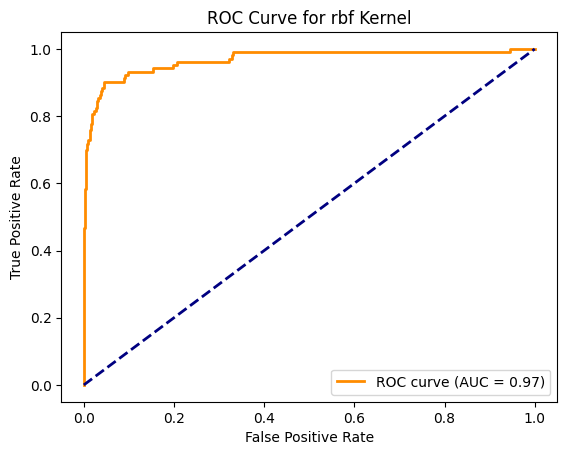

Best kernel: rbf
Best parameters: {'C': 100, 'gamma': 0.01}
              precision    recall  f1-score   support

          -1       0.97      0.97      0.97       525
           1       0.85      0.83      0.84       103

    accuracy                           0.95       628
   macro avg       0.91      0.90      0.90       628
weighted avg       0.95      0.95      0.95       628

Best score: 0.9306160587192149


In [13]:
from sklearn.metrics import roc_curve, auc

# extract best model and parameters
best_kernel = max(results, key=lambda k: results[k]['best_score'])
best_model = results[best_kernel]['best_estimator']

y_test_pred = best_model.predict(X_test)

# save confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# ROC curve
if best_kernel in ['rbf', 'poly', 'linear']:
    y_test_scores = best_model.decision_function(X_test)
else:
    y_test_scores = best_model.predict_proba(X_test)[:, 1] \

fpr, tpr, _ = roc_curve(y_test, y_test_scores)
roc_auc = auc(fpr, tpr)

# plot curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {best_kernel} Kernel')
plt.legend(loc="lower right")
plt.show()

print(f"Best kernel: {best_kernel}")
print(f"Best parameters: {results[best_kernel]['best_params']}")
print(classification_report(y_test, y_test_pred))
print(f"Best score: {results[best_kernel]['best_score']}")

<function matplotlib.pyplot.show(close=None, block=None)>

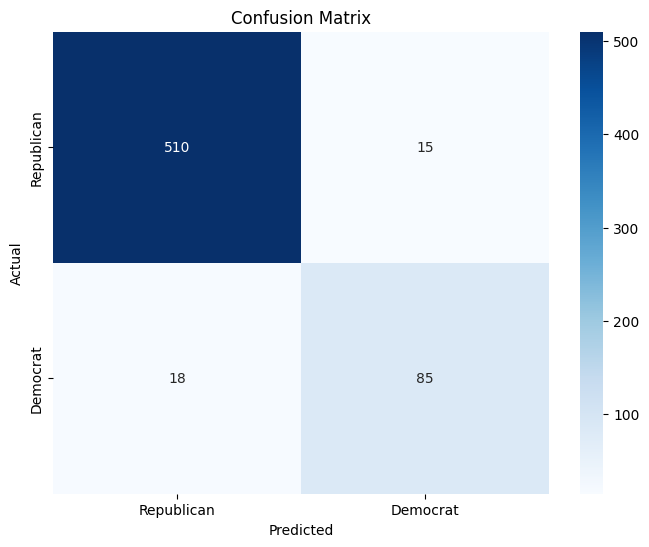

In [14]:
# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Republican', 'Democrat'], yticklabels=['Republican', 'Democrat'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show